In [33]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pim_tmr as pim
import matrices as pim_mats
import fibernet
import torch
from tmr.tmr import TMR, exponential_strategy
import matplotlib.pyplot as plt

from pim_tmr import wirtinger_initialization
from tmr.utils import get_subsets

import mat73
import os
from scipy.io import loadmat

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
path = "C:\\Users\\saucourt\\Datasets"
file = "data_base_02_03_90deg.mat"
data = mat73.loadmat(os.path.join(path, file))
# data = loadmat(os.path.join(path, file))

In [6]:
def select_pixels(img, idxs):
    idxs = idxs.astype(int)
    X, Y = np.meshgrid(idxs, idxs)
    img = img[X.flatten(), Y.flatten()]
    img = np.reshape(img, (len(idxs), len(idxs)))
    return img

In [7]:
CP = np.reshape(np.array(data['CP']), newshape=(-1, 128, 128))
vec = np.reshape(np.array(data['vecteur_36']) , newshape=(-1, 36))

NN = CP.shape[0]
As = np.zeros(shape=(NN, 32), dtype=complex)
Bs = np.zeros(shape=(NN, 122*122), dtype=float)

amp = fibernet.dataset._utils.make_bellshaped_plane_2d(vec[0].reshape((6,6)))
amp = amp.flatten()

idxs = np.arange(4, 122, 128/30).astype(int)
print(idxs.shape)
Bs = np.zeros(shape=(NN, len(idxs)**2), dtype=float)


for i in range(NN):
    phi = vec[i]
    phi = amp * np.exp(1j * phi)
    phi = np.delete(vec[i], [0, 5, 30, 35])
    img = CP[i][3:125, 3:125]
    img = select_pixels(img, idxs)
    img = img.flatten().astype('float')
    As[i,:] = phi
    Bs[i,:] = np.sqrt(img)


(28,)


In [26]:
print(As.shape)

(30000, 32)


Iteration:   1 - distance = 3.723e-01 - stopping distance = 2.349e-02
Iteration:   2 - distance = 3.627e-01 - stopping distance = 9.662e-03
Iteration:   3 - distance = 3.577e-01 - stopping distance = 5.004e-03
Iteration:   4 - distance = 3.548e-01 - stopping distance = 2.844e-03
Iteration:   5 - distance = 3.527e-01 - stopping distance = 2.115e-03
Iteration:   6 - distance = 3.510e-01 - stopping distance = 1.756e-03
Iteration:   7 - distance = 3.495e-01 - stopping distance = 1.497e-03
Iteration:   8 - distance = 3.481e-01 - stopping distance = 1.394e-03
Iteration:   9 - distance = 3.468e-01 - stopping distance = 1.287e-03
Iteration:  10 - distance = 3.456e-01 - stopping distance = 1.210e-03
Iteration:  11 - distance = 3.445e-01 - stopping distance = 1.117e-03
Iteration:  12 - distance = 3.434e-01 - stopping distance = 1.041e-03
Iteration:  13 - distance = 3.424e-01 - stopping distance = 1.044e-03
Iteration:  14 - distance = 3.414e-01 - stopping distance = 9.565e-04
Iteration:  15 - dis

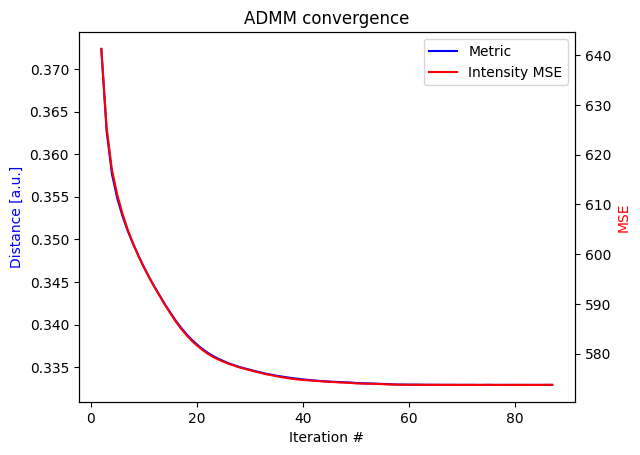

In [42]:
torch.cuda.empty_cache()
N = 1000
As_crop, Bs_crop = get_subsets(As, Bs, N=N, randomize=False)

# Tolerance criterion has to be adjusted to be realistic and ensure the convergence
# init = wirtinger_initialization(As_crop, Bs_crop)
# X_est = pim.pim_tmr(As_crop, Bs_crop, max_iter=100, tol=12e-9, tol_stag=1e-2, max_stag=10)

tmr = TMR(As_crop, Bs_crop, verbose=True, device='cuda')
tmr.run_admm(max_iter=100, lr=1e-2, tol=1e-7, rho=1)
tmr.show_results()

573.6933104215431


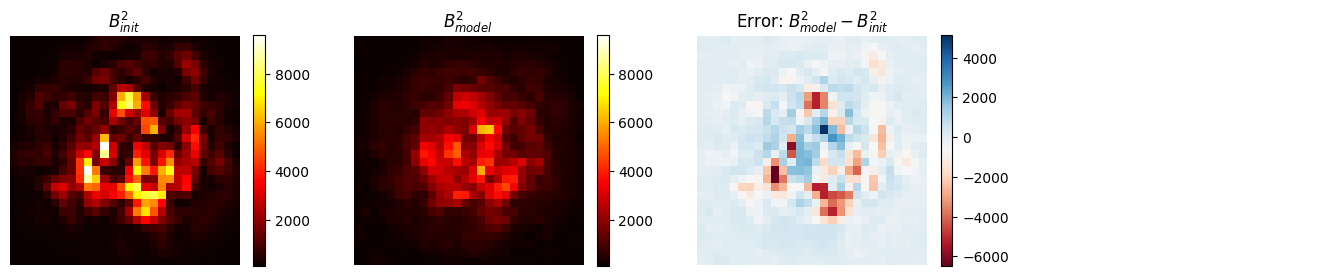

In [43]:
# i = np.random.randint(0, N)
i = 50
A_init = As_crop
Y_model = np.dot(A_init, tmr.X_best)
# Y_model = np.dot(A_init, X_est)
B_model = np.abs(Y_model)
B_init = Bs_crop

b_init_check = np.reshape(B_init[i,:], (len(idxs),len(idxs)))
b_model_check = np.reshape(B_model[i,:], (len(idxs),len(idxs)))

fig, axs = plt.subplots(1,4, figsize=(17,3))
pl0 = axs[0].imshow(np.square(b_init_check ), cmap="hot")
pl1 = axs[1].imshow(np.square(b_model_check), cmap="hot", vmin=np.min(np.square(b_init_check )), vmax=np.max(np.square(b_init_check )))
pl2 = axs[2].imshow(np.square(b_model_check) - np.square(b_init_check), cmap="RdBu")
# pl3 = axs[3].imshow(np.angle(Y_model[:,i]), cmap="twilight")
plt.colorbar(pl0, ax=axs[0])
plt.colorbar(pl1, ax=axs[1])
plt.colorbar(pl2, ax=axs[2])
# plt.colorbar(pl3, ax=axs[3])
axs[0].set_title(r"$B_{init}^2$")
axs[1].set_title(r"$B_{model}^2$")
axs[2].set_title(r"Error: $B_{model}^2 - B_{init}^2$")
# axs[3].set_title(r"$\angle Y_{model}$")
[ axs[i].axis('off') for i in range(4) ]

MSE = np.mean(np.abs(np.square(B_model) - np.square(B_init)))
print(MSE)
